# New York City Taxi Fare Prediction - Data Exploration

## Reading data and first exploration
First thing I like to do with a new dataset is to explore the data. This means investigating the number of features, datatypes, meanings and statistics.

In [1]:
# load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
# read data in pandas dataframe
df_train =  pd.read_csv('E:/NYC_Fare/train_raw.csv', parse_dates=["pickup_datetime"])

# list first few rows (datapoints)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
# check datatypes
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [4]:
# check statistics of the features
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


The following things I notice (while using 500k datapoints):

The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
Some of the minimum and maximum longitude/lattitude coordinates are way off. These I will also remove from the dataset (I will define a bounding box for the coordinates, see further).
The average fare_amount is about  USD11.4 with a standard deviation of USD9.9. When building a predictive model we want to be better than USD9.9  :)

In [5]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 200000
New size: 199987


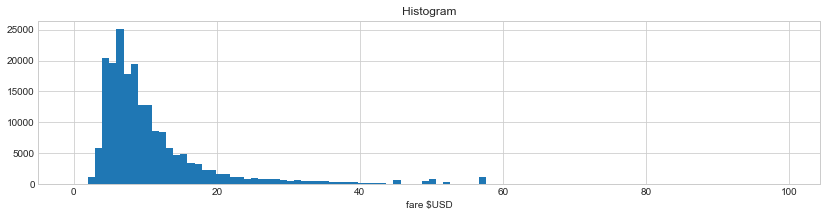

In [6]:
# plot histogram of fare
df_train[df_train.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In the histogram of the fare_amount there are some small spikes between USD40 and USD60. This could indicate some fixed fare price (e.g. to/from airport). This will be explored further below.

Remove missing data

Always check to see if there is missing data. As this dataset is huge, removing datapoints with missing data probably has no effect on the models beings trained.

In [7]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [8]:
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 199987
New size: 199986


## Test data
Read the test data to check the statistics and compare with the training set.

## Location data
As we're dealing with location data, I want to plot the coordinates on a map. This gives a better view of the data. For this, I use the following website:

Easy to use map and GPS tool: https://www.gps-coordinates.net/
Calculate distance between locations: https://www.travelmath.com/flying-distance/
Open street map to grab using bouding box on a map: https://www.openstreetmap.org/export#map=8/52.154/5.295
New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

longitude = -74.0063889
lattitude = 40.7141667
I define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, I'm sure to train a model for the full pickup/dropoff coordinate range of the test set.

From Open Street Map I grab a map and I drop any datapoint outside this box.

In [9]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [10]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 199986
New size: 195801


In [11]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

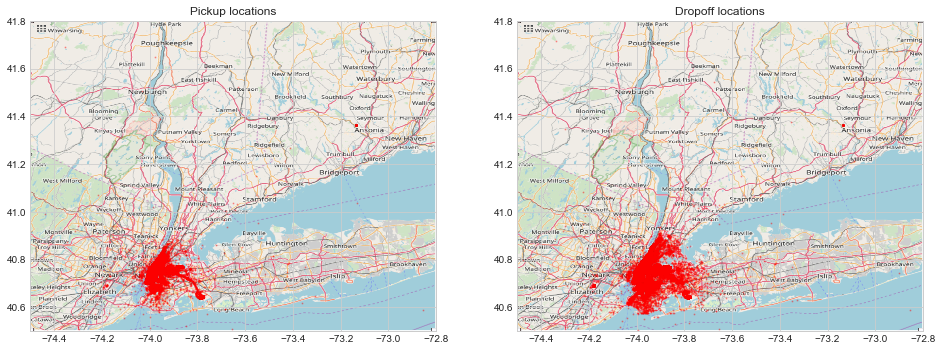

In [12]:
# plot training data on map
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

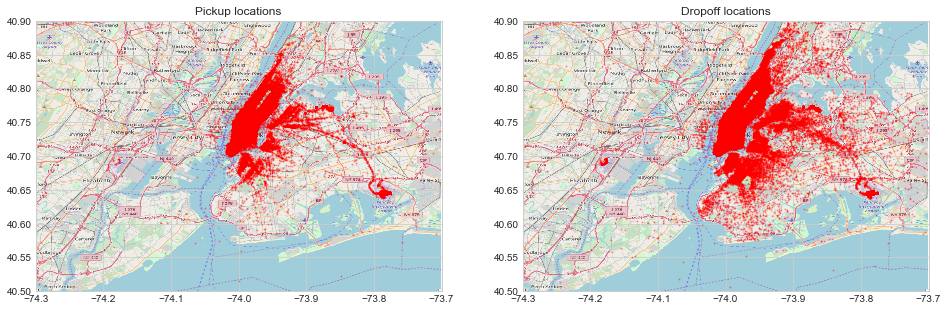

In [13]:
# plot training data on map zoomed in
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

## Removing datapoints in water
As can be seen from the map + scatter plots above, some datapoints are located in the water. These are obviously noisy datapoints. To remove these datapoints, I create a boolean land/water map from the NYC map. For this I used Photoshop to threshold on the blue color of the water and to cleanup the map. The resulting map is show below.

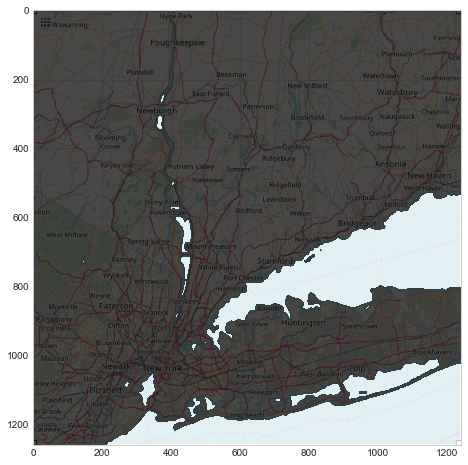

In [14]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

Next, I need to convert longitude/latitude coordinates to xy pixel coordinates. The function lonlat_to_xy implements this transformation. Note that the y coordinate needs to be reversed as the image y-axis is directed from top to bottom.

Once for all datapoints the xy pixel coordinates are calculate, a boolean index is calculated using the NYC mask.

In [15]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [16]:
pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [17]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 34


In [18]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [19]:
print('Old size: %d' % len(df_train))
df_train = remove_datapoints_from_water(df_train)
print('New size: %d' % len(df_train))

Old size: 195801
New size: 195767


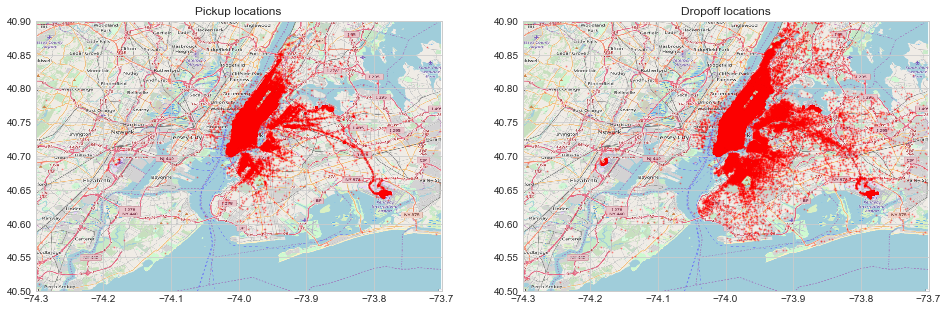

In [20]:
# plot training data
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

## Datapoint density per sq mile
A scatterplot of the pickup and dropoff locations gives a quick impression of the density. However, it is more accurate to count the number of datapoints per area to visualize the density. The code below counts pickup and dropoff datapoints per sq miles. This gives a better view on the 'hot spots'.

In [21]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(df_train.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(df_train.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(df_train.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(df_train.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

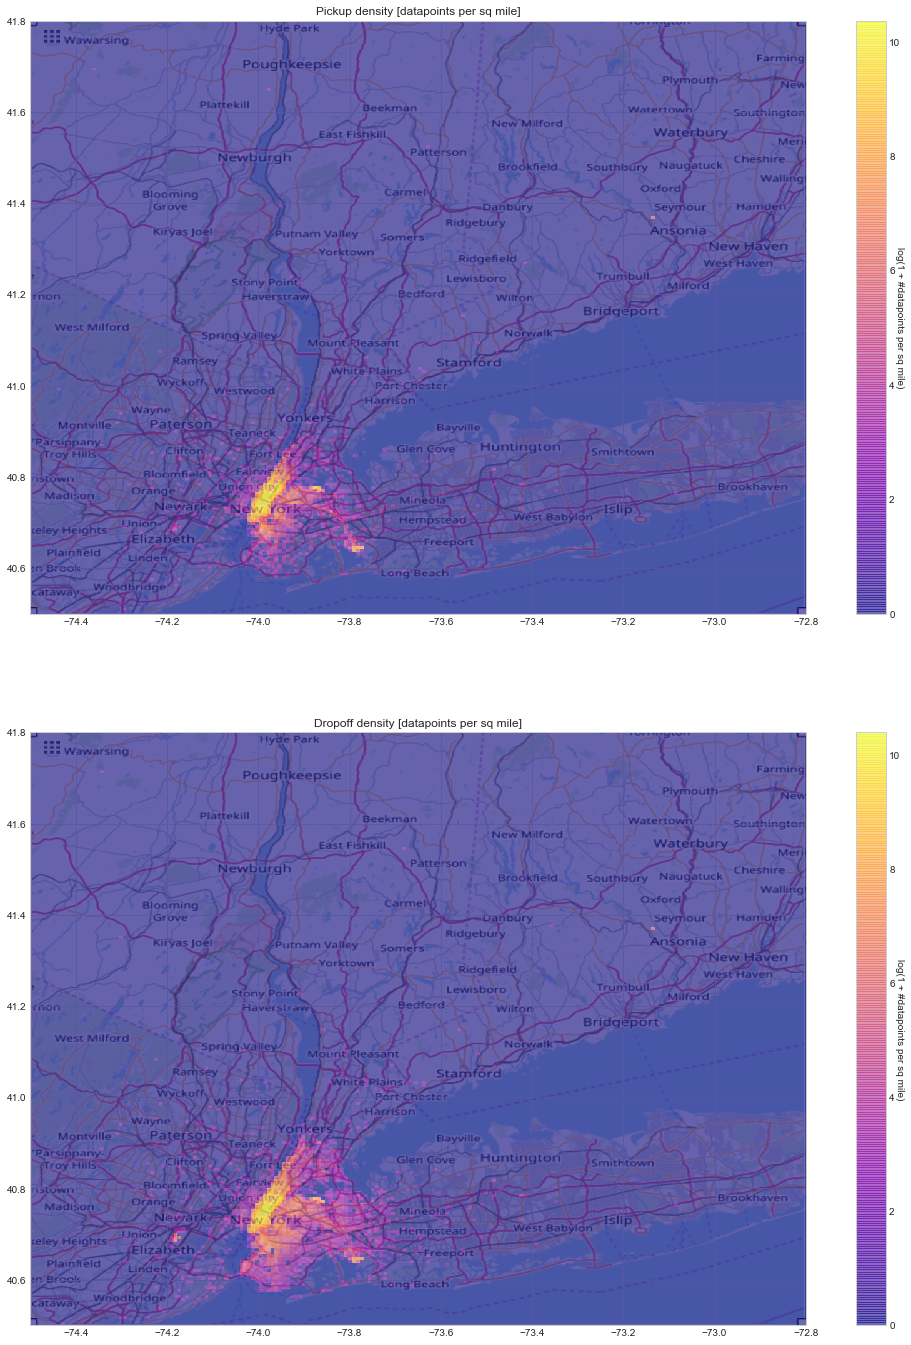

In [22]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

axs[1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

These plots clearly show that the datapoints concentrate around Manhatten and the three airports (JFK, EWS, LGR). There is also a hotspot near Seymour (upper right corner). As I'm not from the US, does somebody has an idea what's so special about this location?

## Distance and time visualisations
Before building a model I want to test some basic 'intuition':

The longer the distance between pickup and dropoff location, the higher the fare.
Some trips, like to/from an airport, are fixed fee.
Fare at night is different from day time.
So, let's check.

### The longer the distance between pickup and dropoff location, the higher the fare
To visualize the distance - fare relation we need to calculate the distance of a trip first.

count    195767.000000
mean          2.070060
std           2.364879
min           0.000000
25%           0.780658
50%           1.338753
75%           2.427781
max          64.644331
Name: distance_miles, dtype: float64

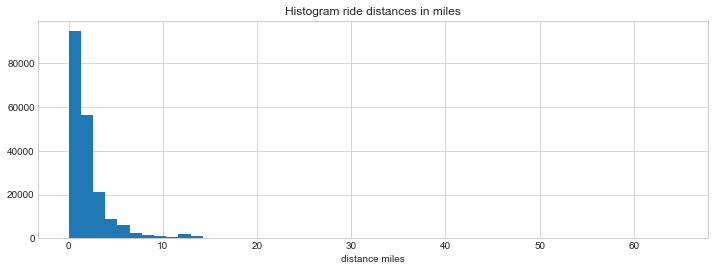

In [23]:
# add new column to dataframe with distance in miles
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

df_train.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
df_train.distance_miles.describe()

It seems that most rides are just short rides, with a small peak at ~13 miles. This peak could be due to airport drives.

Let's also see the influence of passenger_count.